In [2]:
import librosa as lb
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from librosa.display import specshow, waveplot
from pydub import AudioSegment
np.random.seed(9) #For the Mighty Nein!

import autoreload
%load_ext autoreload
%autoreload 2

import scripts.sound_feature_extraction as sfe
import scripts.common_quick_plots as qp

# Phase 1 - Problem Definition

## 1.1 Broad Goals

A Speech Emotion Recognition (SER) model allows a program to correctly identify the emotional state of a speaker.  The community of data scientists working on the SER problem is currently split between two main methodolgies-- using sound data transformations and using spectrogram arrays as image data with a convolutional neural network.  This project's purpose is to examine the two methodologies and determine which is more suited for adaptation to working with real-time speech emotion classification instead of pre-existing samples.

## 1.2 Data Source

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) includes 24 professional voice actors, 12 male, 12 female speaking the same two lines.  The full dataset includes both audio and visual files.  

### Spoken Files
| Actor |  Emotion | Intensity      | Statement | Repetition |
| :---: |:--------:| :-------------:| :--------:| :--------: |
| 01- 24| calm     | normal, strong | 01, 02    |  01, 02    |
| 01- 24| happy    | normal, strong | 01, 02    |  01, 02    |
| 01- 24| sad      | normal, strong | 01, 02    |  01, 02    |
| 01- 24| angry    | normal, strong | 01, 02    |  01, 02    |
| 01- 24| fearful  | normal, strong | 01, 02    |  01, 02    |
| 01- 24| surprise | normal, strong | 01, 02    |  01, 02    |
| 01- 24| disgust  | normal, strong | 01, 02    |  01, 02    |
| 01- 24| neutral  | normal         | 01, 02    |  01, 02    |

Statement 01:  "Kids are talking by the door"

Statement 02:  "Dogs are sitting by the door"

Intensity 01:  "Normal"

Intensity 02:  "Strong"

### Song Files
| Actor |  Emotion | Intensity      | Statement | Repetition |
| :---: |:--------:| :-------------:| :--------:| :--------: |
| 01- 24| calm     | normal, strong | 01, 02    |  01, 02    |
| 01- 24| happy    | normal, strong | 01, 02    |  01, 02    |
| 01- 24| sad      | normal, strong | 01, 02    |  01, 02    |
| 01- 24| angry    | normal, strong | 01, 02    |  01, 02    |
| 01- 24| fearful  | normal, strong | 01, 02    |  01, 02    |




Full Dataset available at:
https://smartlaboratory.org/ravdess/


For the purposes of this project we will be examining the audio-only files.

## Phase 2: Data Gathering

### 2.1 Load targets to DF

In [3]:
tar_emotions = ['happy', 'sad', 'angry', 'fearful']
actor_10 = sfe.load_targets(tar_emotions, '10')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/preprocess

In [4]:
actor_10.head()

,file_name,emotion,statement,channel,mfccs,melspec,chroma,wave,duration,sr,flat_feature,feature_array
0,03-02-05-01-02-01-10,angry,Dogs are sitting by the door,song,"[[-1.2607541, -1.2580315, -1.2569079, -1.26126...","[[-0.35065755, -0.27974886, -0.24198592, -0.38...","[[2.0201545, 1.7276788, 1.863125, 0.17764209, ...","[2.0797295e-05, 3.5788195e-05, 1.5184007e-05, ...",4.604626,22050,"[-449.70578, 28.980103, -20.934938, 4.7438617,...","[[-1.2607541, -1.2580315, -1.2569079, -1.26126..."
1,03-01-03-02-02-02-10,happy,Dogs are sitting by the door,speech,"[[-1.3918377, -1.3918377, -1.3916175, -1.38962...","[[-0.14113592, -0.14071508, -0.14052716, -0.14...","[[0.4877635, 0.53198725, 1.6737871, 1.073376, ...","[-9.470912e-06, -3.086568e-05, -6.716728e-06, ...",3.970658,22050,"[-358.90125, 27.535181, -31.962467, -0.3631144...","[[-1.3918377, -1.3918377, -1.3916175, -1.38962..."
2,03-02-06-01-02-02-10,fearful,Dogs are sitting by the door,song,"[[-1.0693251, -1.0660956, -1.0669044, -1.07258...","[[0.06687308, 0.1648016, -0.07191896, -0.54035...","[[0.74195784, 1.1126485, 0.47712767, -0.226919...","[4.3174496e-05, 6.7743786e-05, 8.063262e-05, 0...",4.704717,22050,"[-519.9812, 31.606262, -6.8212767, -0.8707459,...","[[-1.0693251, -1.0660956, -1.0669044, -1.07258..."
3,03-02-06-02-01-02-10,fearful,Kids are talking by the door,song,"[[-1.2675465, -1.263367, -1.2626477, -1.267227...","[[-0.58310395, 0.028269563, 0.15944438, -0.508...","[[1.9207904, 2.0740488, 1.3160877, 1.5136135, ...","[1.8449151e-05, 2.1872691e-05, 8.0995505e-07, ...",4.604626,22050,"[-426.03595, 32.351036, -32.652767, 4.0545797,...","[[-1.2675465, -1.263367, -1.2626477, -1.267227..."
4,03-01-03-01-01-02-10,happy,Kids are talking by the door,speech,"[[-1.366791, -1.3719172, -1.3736181, -1.37374,...","[[1.0512705, 0.3516646, -0.23362, -0.19019349,...","[[0.84654516, 1.3959845, 1.1932441, 1.2104808,...","[1.8911045e-05, 1.4877349e-05, 5.378921e-06, 1...",3.470159,22050,"[-499.81458, 46.448856, -10.837826, 4.436974, ...","[[-1.366791, -1.3719172, -1.3736181, -1.37374,..."


In [5]:
a10_s01 = actor_10[actor_10['statement'] == sfe.statements['01']].copy()
a10_s02 = actor_10[actor_10['statement'] == sfe.statements['02']].copy()

## Phase 3: Exploratory Data Analysis

The Ravdess Dataset is very well defined and is balanced by design.  Each of 24 actor records the same two lines 4 times over, two repetitions each of each of two emotional intensities.  For 5 out of 8 emotions, we also have the same in song form instead of speech. Meaning, that for five out of the eight labelled emotions in the dataset, we have 192 samples and the remaining three emotions we only have 96.  Additionally, this assumes that the model will perform equally well on speech and song sample types when it comes to classifying emotions.

So let's dig in to the differences here, look at the data with several common transformations, and determine if we can comfortably include both speech and song emotion samples in our final dataset.  For the purposes of the EDA segment, we're going to be looking at only a few specific actors to get to know what our preprocessed data looks like and begin ingestigating trends.

The librosa sound code library allows for quite a few visualizations, the most interesting ones are the spectrograms and waveforms.

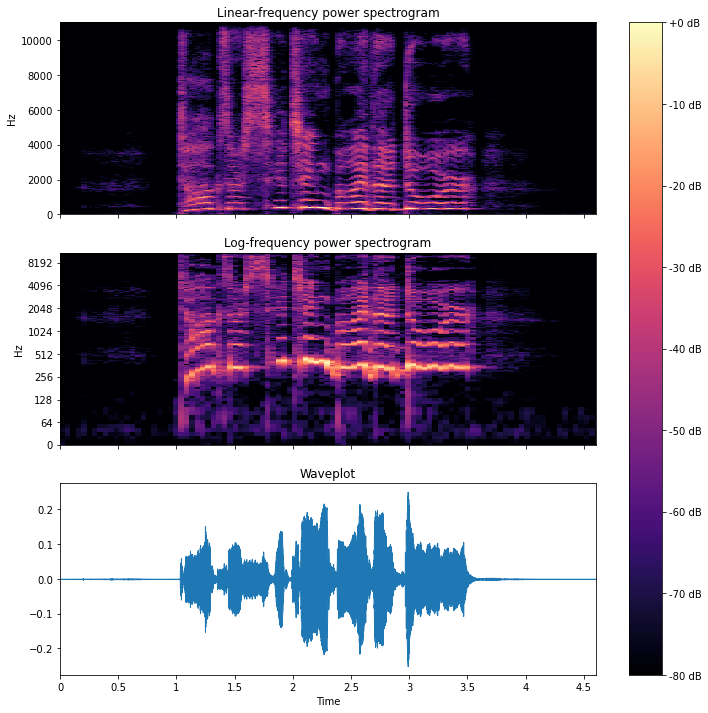

In [6]:
qp.plot_spectrograms_and_waveform(actor_10.loc[0, 'wave'])
plt.savefig('./imgs/combinedvisualizations.jpg')

### 3.1 Waveplots

The plot above shows three different methods of examining the same sound window side by side. Given the nature of sound information as a time series object, the bottom-most figure labeled 'waveplot' will be the most familiar to readers.  The librosa library preprocesses a waveform by taking slices from the waveform at a preset rate to generate a reproducable series of samples from which the waveform can be recreated. There are limitations to this in that if the sample rate is too low or too high, it can created multiple possible waveforms from the same sample slices-- according to Nyquist Theorem, the sampling rate must be at least double the highest analog frequency component (aka hz or Hertz) or the sample will not be able to used to recreate the sound.  Given that the range of human perception is between 20 and 20,000 hz and the range of intelligible human speech is between 1,000 and 10,000 hz, the librosa sound library's standard sampling rate of 22,050 should be capable of accurately capturing all waveforms in human speech patterns and we can accept it as the standard for our preprocessing.

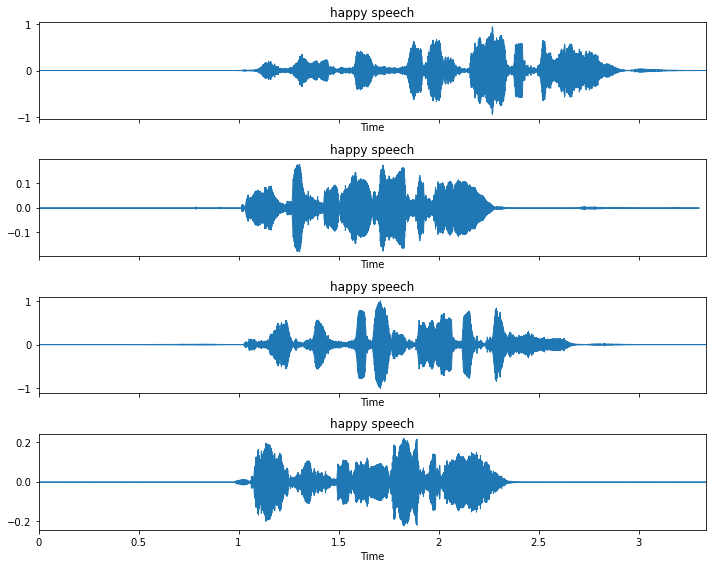

In [7]:
qp.plot_waves(a10_s02, ['happy'], channels = ['speech'], figsize = (10, 8))
plt.savefig('./imgs/waveforms/happy_speeches.jpg')

Looking at the first emotion on the list, 'happy,' across the four iterations of both speech and song for actor number 10 (chosen at random) and statement number 2, 'Dogs are sitting by the door', we can start to see a pattern emerge in the waveforms.  

    1. Each word shows up as a distinct spike in the time intervals, whether its in speech or song.
    2. There is an immediately visible difference in the amplitude of the pattern for two of the speeches.  This is most likely the 'low' and 'high' intensities.
    
Let's check to see how much this changes across vocal channels, or if it's consistent 

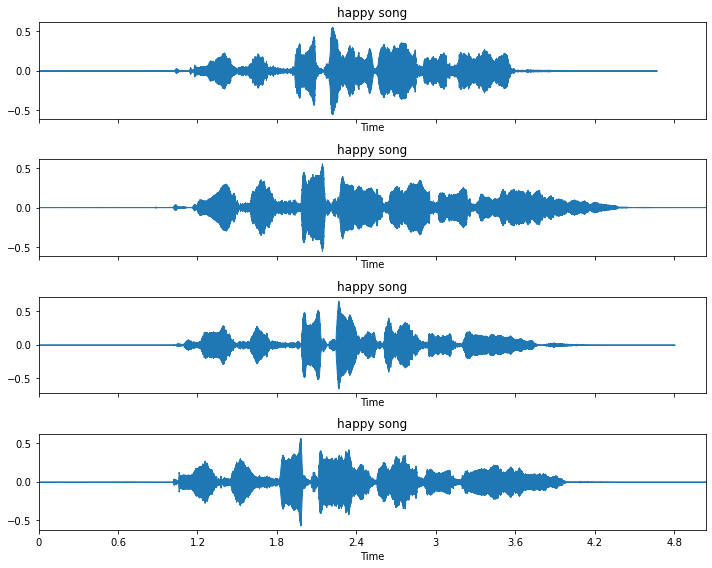

In [8]:
qp.plot_waves(a10_s02, ['happy'], channels = ['song'], figsize = (10, 8))
plt.savefig('./imgs/waveforms/happy_songs.jpg')

One new observation: 

Song files tend to spread the waveform across a longer range.  The figures in the first set are consistently showing the statement having been finished by the 3 second mark whereas the second set of figures (song) regularly extends past the 3.5s mark.  While an interesting difference, not a significant one.

Let's move on to other emotions and see if we can find similar patterns.

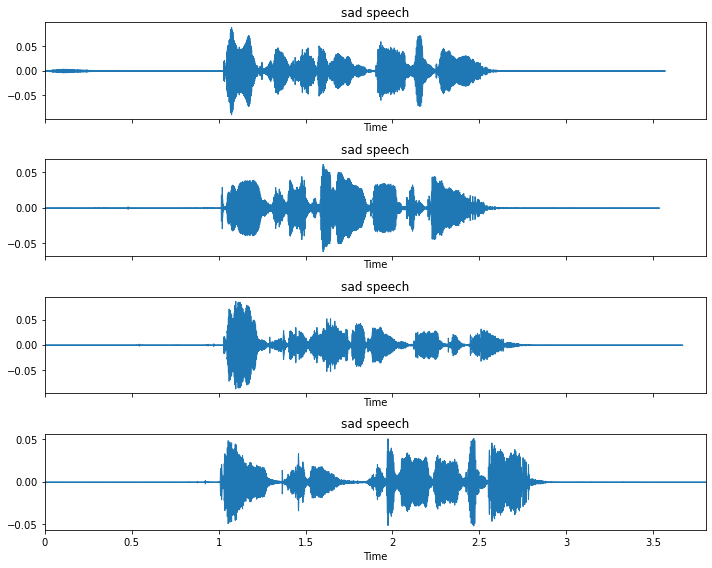

In [9]:
qp.plot_waves(a10_s02, emotions = ['sad'], figsize = (10, 8))
plt.savefig('./imgs/waveforms/sad_speeches.jpg')

So far so good!  We're seeing those two factors are remaining consistent across the samples and across the vocal channels.  We're also showing that while the patterns are similar, they are not identical.  This is promising as it indicates there is variation between emotions which our model might be able to pick up on.  

Let's try a third.

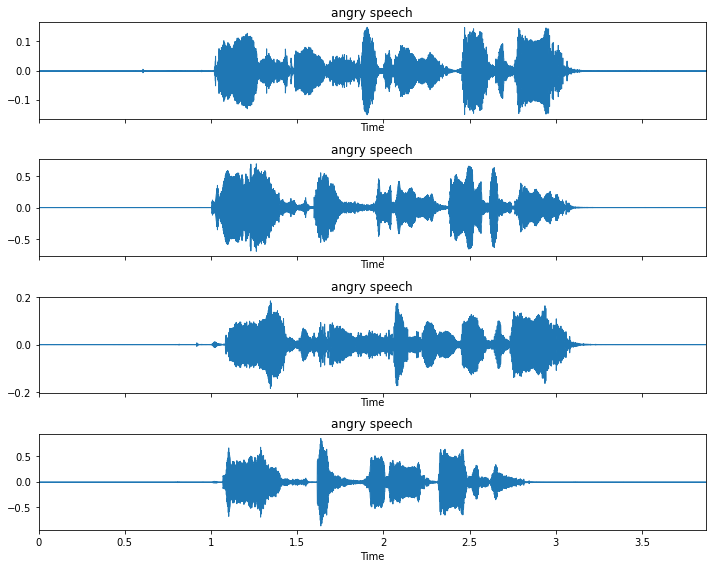

In [10]:
qp.plot_waves(a10_s02, ['angry'], figsize = (10, 8))
plt.savefig('./imgs/waveforms/angry_speeches.jpg')

In this case, the two main observations 1 and 2 continue to hold, this is enough to work with.

### 3.2 Spectrograms Overview

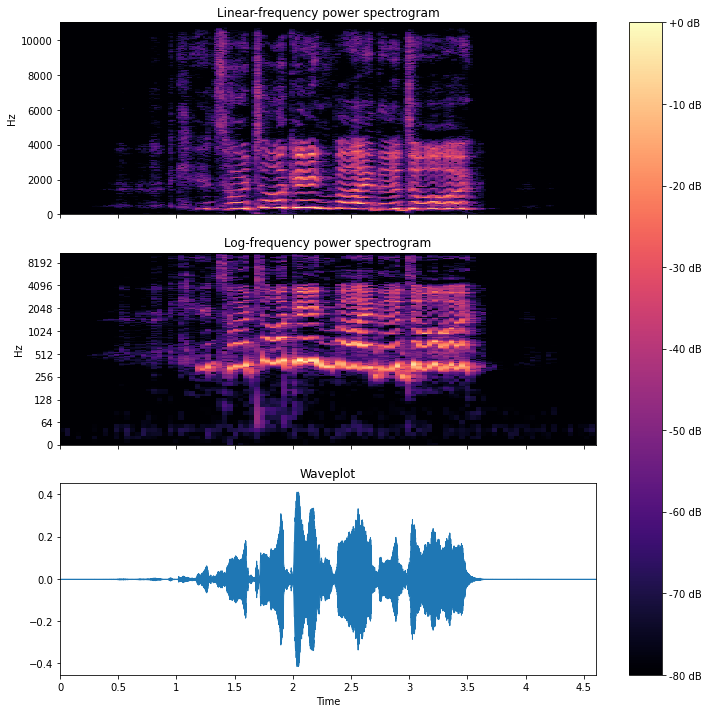

In [11]:
qp.plot_spectrograms_and_waveform(actor_10.loc[3, 'wave'])

If we refer back to the three main methods of looking at the soundfile that we explored in the first section, we see that two of them are variations on spectrograms, so let's dig into those a bit more.

Spectrograms accomplish several specific things-  they allows us to visualize the sound frequencies in the file and they allow us to add an additional dimension of volume in decibles through the inclusion of color.  Similar to heatmaps and density plots, this allows us additional insights.

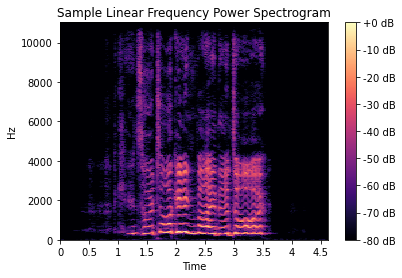

In [12]:
y = actor_10.loc[3, 'wave']
hop_length = 1024
D = lb.amplitude_to_db(np.abs(lb.stft(y)), ref=np.max)
img = lb.display.specshow(D, y_axis='linear', x_axis='time', sr=22050)
plt.colorbar(img, format="%+2.f dB")
plt.title('Sample Linear Frequency Power Spectrogram');
plt.savefig('./imgs/spectrograms/sample_linear_spectrogram.jpg')

This is a sample spectrogram, with hz on the y axis and the time index on the x, with the relative volume in dB plotted in color according to the colorbar on the right.  Note that it is clustered at the lower end of the scale and bears a passing similarity to the waveforms we examined previously.

Let's try looking at a log frequency instead to see if we can make this somewhat less crowded.

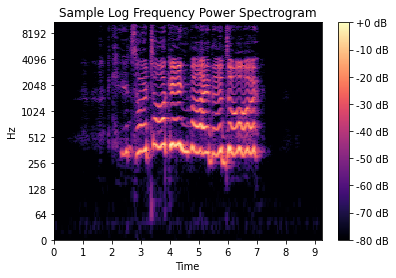

In [13]:
lb.display.specshow(D, y_axis='log', x_axis='time', sr=22050, hop_length = hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('Sample Log Frequency Power Spectrogram')
plt.savefig('./imgs/spectrograms/sample_log_spectrogram.jpg');

All right!  Now we're showing distinct patterns that are quickly visible, this is promising.  The backgroud literature discusses the common use of MFCC's or Mel-Frequency Cepstrum Coefficients in speech recognition, so let's take a look at what this same sound looks like on the mel scale.

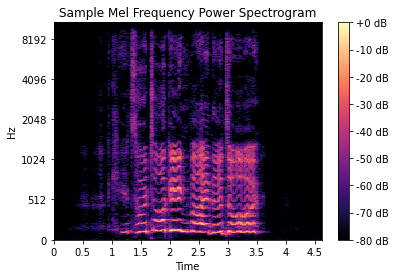

In [14]:
lb.display.specshow(D, y_axis='mel', x_axis='time', sr=22050)
plt.colorbar(img, format="%+2.f dB")
plt.title('Sample Mel Frequency Power Spectrogram')
plt.savefig('./imgs/spectrograms/sample_mel_spectrogram.jpg');

Overall, this is similar to the original linear-frequency power spectrogram, only with less blur.  If we decided to treat the sound files as images and apply 2D convlolutional pooling to the neural network, this is a promising transformation to apply.

### 3.3 Comparative Spectrograms

Because we've seen several different types of spectrograms and the log-frequency transformed spectrogram is shows the most visibility, I'm going to use this version for our comparisons.  Let's take a look at some emotions side by side with a log frequency spectrogram.

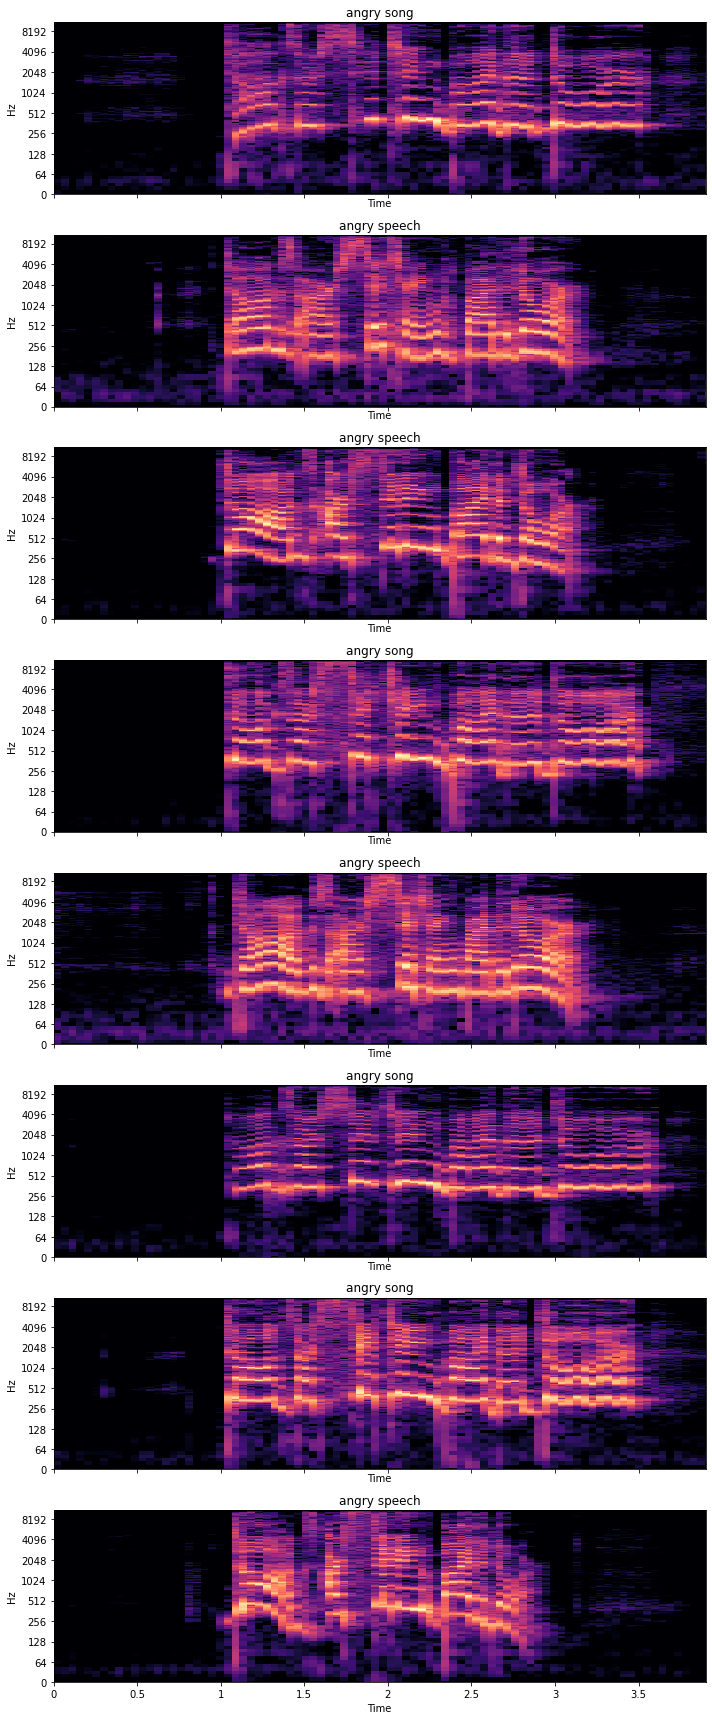

In [15]:
qp.plot_log_spectrograms(a10_s02, ['angry'], (10, 24))
plt.savefig('./imgs/spectrograms/angry_spectrograms.jpg');

For this plot, we're looking at speech and song log frequency power spectrogramgs side by side within the emotional tilt of anger.  If you note the hz, we're seeing that even with the log transforms the angry speeches are spread across more of the spectrum.  

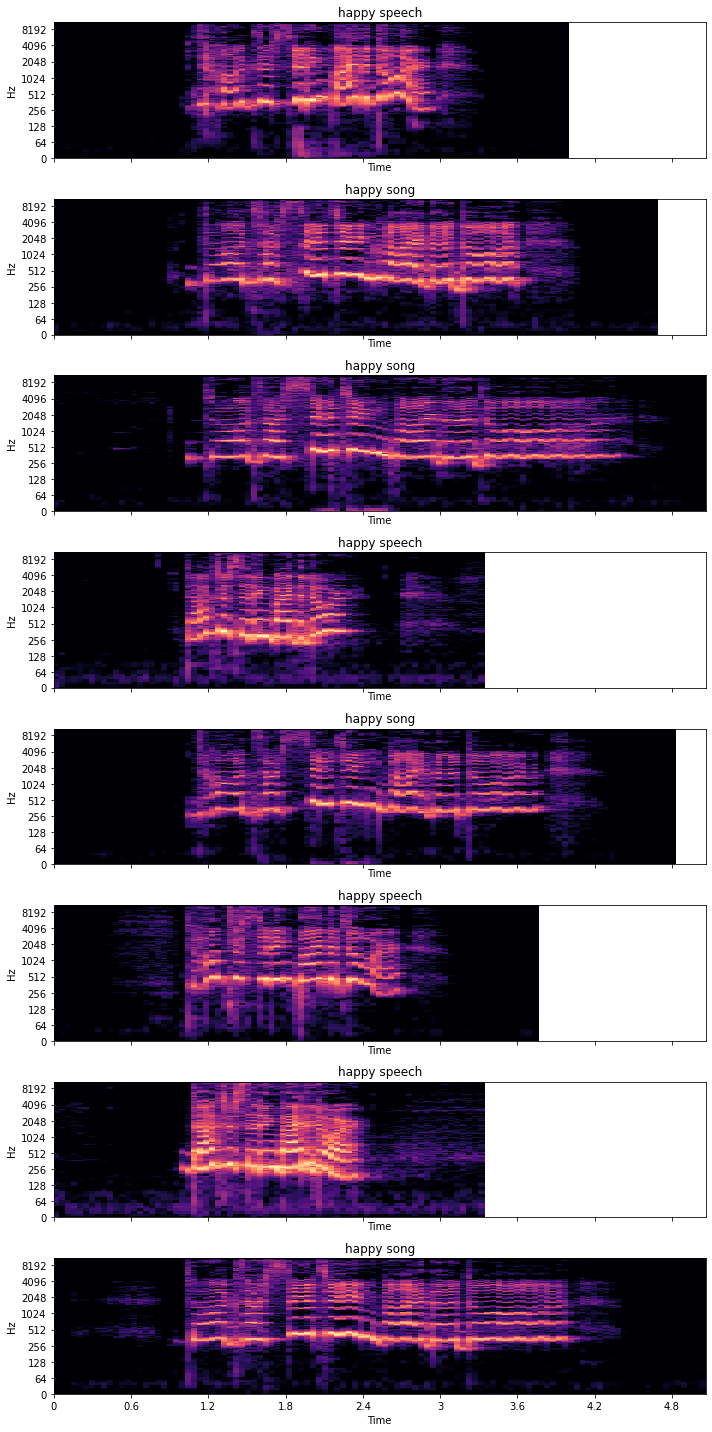

In [16]:
qp.plot_log_spectrograms(a10_s02, emotions = ['happy'], figsize = (10, 20))
plt.savefig('./imgs/spectrograms/happy_spectrograms.jpg');

Maintaining the time signature on the X axis shows us even more clearly that the time windows vary between the speech and song channels.  It may be necessary to look at each modality separately in order to prevent the model simply selecting for length and modeling the vocal channel instead of the emotional inflections.

Let's look now at the difference between those emotional inflections. First, we'll need to slice the dataframe again to only look at speech.

In [17]:
a10_sp01 = actor_10[(actor_10['statement'] == sfe.statements['01']) & (actor_10['channel'] == 'speech')].copy()

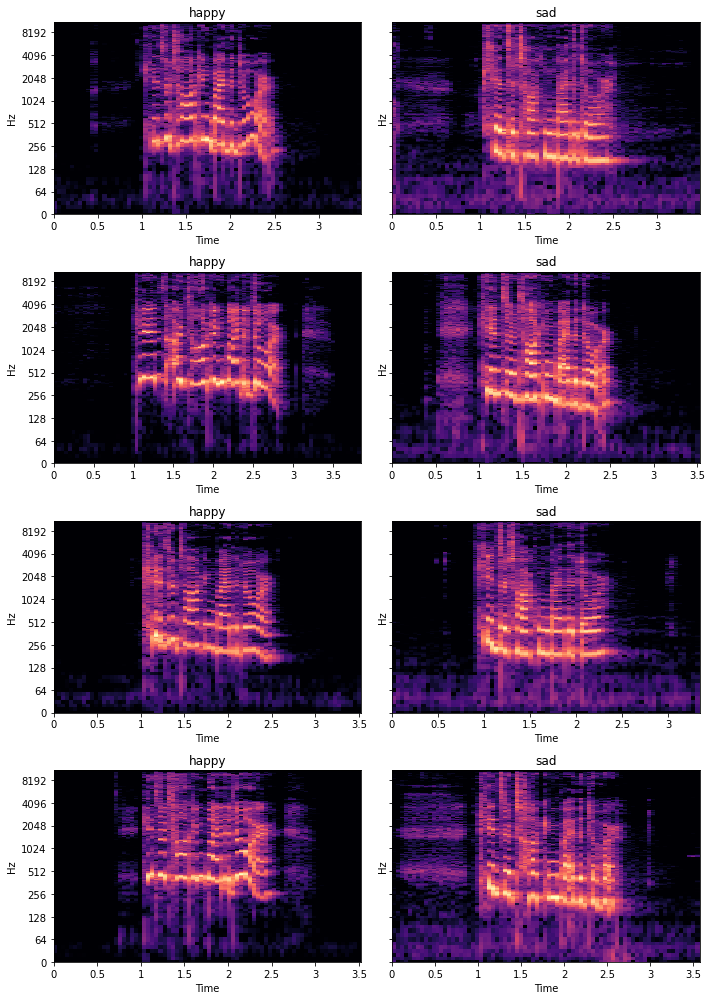

In [18]:
qp.plot_log_spectrograms(a10_sp01, emotions = ['happy', 'sad'], figsize = (10, 14))
plt.savefig('./imgs/spectrograms/happy_and_sad_spectrograms.jpg');

Interesting, I'm reading the decibel intensity spread out more across the hz spectrum in the sad samples instead of the happy samples.  Let's see what happens when I compare a larger sample of emotions side by side.

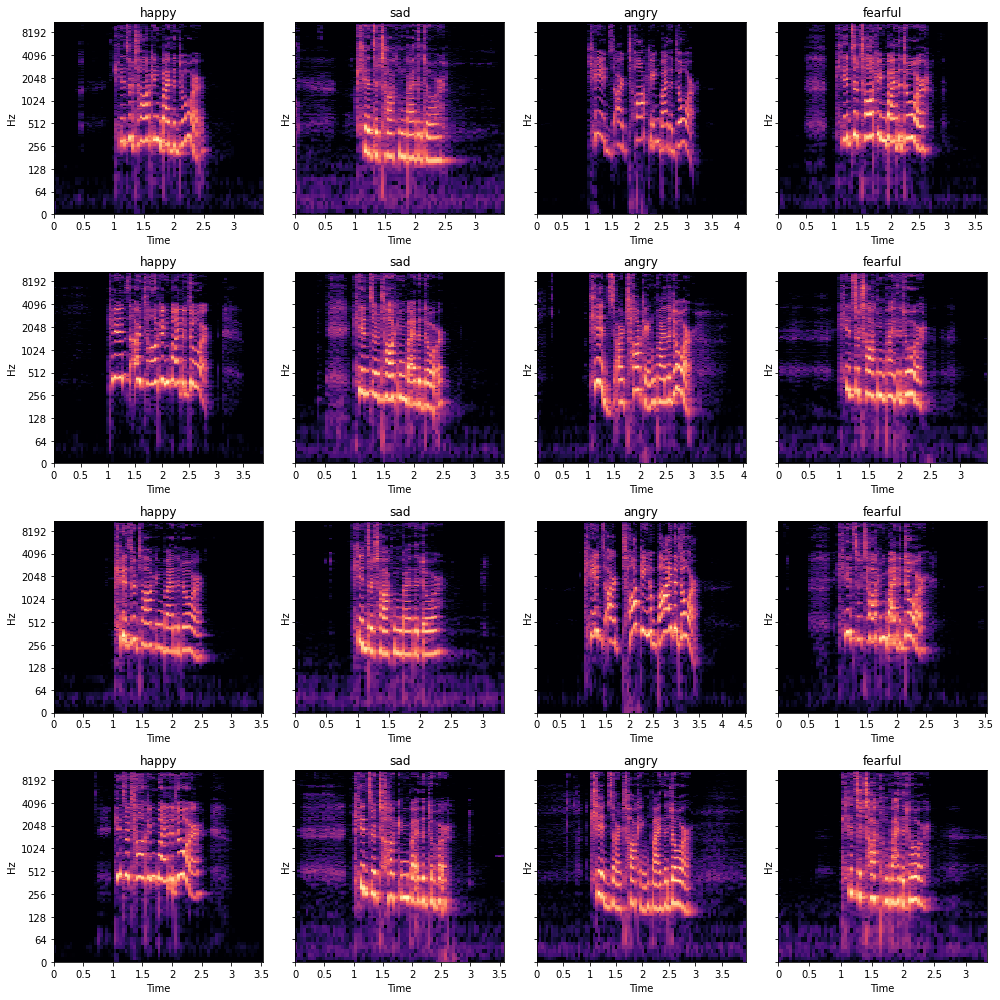

In [19]:
qp.plot_log_spectrograms(a10_sp01, emotions = tar_emotions, figsize = (14, 14))
plt.savefig('./imgs/spectrograms/big_four_spectrograms.jpg');

The figure above shows all four of the emotions loaded in for comparison.  Looking at the pattern similarity by column, the most easily visible pattern is the 'angry' column shows more peaks and ridges in the samples.

Looking at it from this perspective is limited.  It's time to get the models up and running.